# Trabalho de NLP - Avaliação de word embeddings usando o word2vec 

**Aluno: Daniel Souza de Campos - 2023708898 - 2024/2**

Antes de tudo, é necessário baixar o repositório em https://github.com/nicholas-leonard/word2vec e, dentro da pasta deste, rodar o comando `make` para compilar o word2vec e gerar o seu executável. Além disso, é necessário baixar e extrair o corpus de treinamento disponível em https://mattmahoney.net/dc/text8.zip.

Para executar o notebook, é necessário instalar o pandas, matplotlib, numpy, tqdm e o ipywidgets.

In [1]:
from collections import namedtuple
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pathlib
import subprocess
from tqdm import tqdm

# Definindo parâmetros

Para encontrar a configuração de execução que produz a maior similaridade média, vamos realizar um *grid-search* pelos parâmetros definidos abaixo.

Abaixo também existem parâmetros que indicam os arquivos de entrada e de saída que serão utilizados.

Ao final, é impresso na tela quantas configurações diferentes serão testadas pelo *grid-search*.

In [2]:
# Arquivos de entrada
train_data_path = pathlib.Path("../../../Downloads/text8")
questions_words_path = pathlib.Path("./questions-words.txt")
word2vec_exec_path = pathlib.Path("./word2vec")

#Arquivos de saída
output_emb_path = pathlib.Path("./embeddings.txt")
output_vocab_path = pathlib.Path("./vocab.txt")
output_results_path = pathlib.Path("./results.txt")

if not train_data_path.exists():
    raise ValueError(f"Train file at {train_data_path} doesn't exists!")

if not word2vec_exec_path.exists():
    raise ValueError(f"Word2vec file at {word2vec_exec_path} doesn't exists!")

if not questions_words_path.exists():
    raise ValueError(f"Questions words file at {questions_words_path} doesn't exists!")

output_emb_path.parent.mkdir(exist_ok=True, parents=True)
print(f"Embeddings will be saved at {output_emb_path.resolve()}")

output_vocab_path.parent.mkdir(exist_ok=True, parents=True)
print(f"Vocab will be saved at {output_vocab_path.resolve()}")

output_results_path.parent.mkdir(exist_ok=True, parents=True)
print(f"Results stats will be saved at {output_results_path.resolve()}")

#Outros valores
n_threads=1*4 # Número de threads usadas para o treinamento. No meu caso, usei uma por core

# Valores para o Grid search de hiperparâmetros
cbow_list=(0, 1) # Skip-gram or CBOW 
cts_list=(2, 4, 6, 8, 10) # Context size
emb_list=(32, 64, 128, 256) # Embeddings size
its_list=(1, 3, 5) # Epochs

N_CONFIGS = len(cbow_list) * len(cts_list) * len(emb_list) * len(its_list)
print(f"QT Configs to test: {N_CONFIGS}")

Embeddings will be saved at /home/daniel/Documentos/Git/word2vec-master/embeddings.txt
Vocab will be saved at /home/daniel/Documentos/Git/word2vec-master/vocab.txt
Results stats will be saved at /home/daniel/Documentos/Git/word2vec-master/results.txt
QT Configs to test: 120


# Executando word2vec uma configuração por vez

- Rodamos uma configuração do word2vec por vez usando a quantidade de threads definida anteriormente
- Como o arquivo executável não é um arquivo `.py`, usamos o `subprocess` do python para executar o arquivo alvo
- Só carregamos em memória o mapeamento de palavras e seu id no vocabulário uma vez.
- Salvamos os resultados de testes em analogias em um DataFrame do Pandas para análise posterior.

In [12]:
Config = namedtuple('Config', ['cbow', 'ctxt_size', 'emb_size', 'it'])

def get_new_config(cbows:list[int], context_sizes:list[int], 
                   emb_sizes:list[int], its_to_run:list[int]) -> Config:
    """
    Generator that returns a test config at a time
    """
    for cbow in cbows:
        for cont_size in context_sizes:
            for emb in emb_sizes:
                for it in its_to_run:
                    yield Config(cbow, cont_size, emb, it)

def load_vocab_list(vocab_path:pathlib.Path) -> dict[str, int]:
    """
    Loads the word to id in the vocab mapping and returns a dict
    with the word as a key and its id as a value
    """
    word_to_id = dict()
    with open(vocab_path,'r') as vocab_file:
        for line_id, line in enumerate(vocab_file):
            word_to_id[line.split()[0]] = line_id
    return word_to_id

def load_embeddings_vectors(n_words:int, emb_size:int, 
                            embs_path:pathlib.Path) -> np.ndarray:
    """
    Load the embeddings matrix from a txt file. 
    Return a (n_words, emb_size) sized np.ndarray
    """
    embs_matrix = np.zeros((n_words, emb_size))
    with open(embs_path) as embs:
        for line_id, line in enumerate(embs):
            # Jump header
            if line_id == 0:
                continue
    
            line_embs = [float(emb) for emb in line.split()[1:]]
            embs_matrix[line_id-1]=line_embs
    return embs_matrix

def evaluate_embs(embs:np.ndarray) -> float:
    """
    Evaluate the analogy embeddings as:
    result = embs[1] - embs[0] + embs[2]
    Return cosine_similarity(result, embs[4])
    """
    result = embs[1] - embs[0] + embs[2]
    dot_product = np.dot(result, embs[3])
    magnitude_A = np.linalg.norm(result)
    magnitude_B = np.linalg.norm(embs[3])
    cosine_similarity = dot_product / (magnitude_A * magnitude_B)
    return cosine_similarity

def eval_on_questions(questions_words_path:pathlib.Path, 
                      emb_size:int, embedding_matrix:np.ndarray,
                     word_to_id:dict[str, int]) -> np.ndarray:
    """
    Evaluate the embeddings based on analogy questions using
    cosine similarity
    """
    n_words_in_question = 4
    with open(questions_words_path,'r') as question:
        line_embs = np.empty((n_words_in_question, emb_size))
        sims = list()
        num_questions_processed = 0
        for line_id, line in enumerate(question):
            line_splitted = line.split()

            #Jump headers/checkpoints
            if len(line_splitted) != n_words_in_question:
                continue
    
            try:
                for word_id, word in enumerate(line_splitted):
                    word_id_in_vocab = word_to_id[word.lower()]
                    line_embs[word_id] = embedding_matrix[word_id_in_vocab]
            except Exception as e:
                pass
            else:
                sims.append(evaluate_embs(line_embs))
                
    return np.array(sims)

In [4]:
# If you really want to run every experiment again and override the results
# file, then set this to False. This is useful if you run everything without
# knowing that it will override the results file. Create a copy of the results
# file that might already exist before running the experiments again
SAFEGUARD=True 

In [5]:
if not SAFEGUARD:
    results_df = None
    word_to_id = dict()
    questions_size=None
    for config in tqdm(get_new_config(cbow_list, cts_list, emb_list, its_list), 
                       total=N_CONFIGS, desc="Configs run"):
        
        args = [
                     f"./{str(word2vec_exec_path)}", 
                     "-train", str(train_data_path),
                     "-output", str(output_emb_path), 
                     "-iter", str(config.it),
                     "-size", str(config.emb_size),
                     "-cbow", str(config.cbow),
                     "-window", str(config.ctxt_size)
                 ]
        
        if output_vocab_path.exists():
            args.extend(["-read-vocab", str(output_vocab_path)])
        else:
            args.extend(["-save-vocab", str(output_vocab_path)])
            
        try:
            result = subprocess.run(args, capture_output=True, text=True, check=True)
        except subprocess.CalledProcessError as e:
            print(f"ERROR! Run for config {config} raised an error! Check all your parameters!")
            print(f"Error: {e}\nStopping iterations!")
            break
        else:
            # Load the vocab once for every run as the dataset is fixed
            if len(word_to_id) == 0:
                word_to_id = load_vocab_list(output_vocab_path)
    
            # Load the embeddings once for this run
            embedding_matrix = load_embeddings_vectors(len(word_to_id), 
                                                           config.emb_size,
                                                           output_emb_path)
    
            sims = eval_on_questions(questions_words_path, config.emb_size, 
                                     embedding_matrix, word_to_id)
           
            mean_sim = sims.mean()
            std_sim = sims.std()
            assert mean_sim <= 1, "Similarity score mean can't be greater than 1"
            
            config_df = pd.DataFrame(config._asdict(), index=[0])
            config_df['mean similarity'] = mean_sim
            config_df['std similarity'] = std_sim
            config_df['qt processed'] = sims.size
            results_df = pd.concat([results_df, config_df], axis=0)
        finally:
            pass

    # Save results
    results_df.reset_index(inplace=True, drop=True)
    results_df.to_csv(output_results_path, index=None)

Para testar as 120 configurações, foram necessárias 4 horas usando 4 threads e pico de memória em cerca de 4 GB de memória RAM. 

# Análise de resultados

Vamos ver quais são as 5 configurações que produziram os melhores resultados médios de similaridade

In [6]:
results_df = pd.read_csv(output_results_path)
results_df.shape

(120, 7)

In [7]:
results_df.sort_values(['mean similarity'], ascending=False).head()

,cbow,ctxt_size,emb_size,it,mean similarity,std similarity,qt processed
12,0,4,32,1,0.778025,0.143060,17827
24,0,6,32,1,0.777317,0.133581,17827
0,0,2,32,1,0.777146,0.161597,17827
36,0,8,32,1,0.771684,0.129131,17827
48,0,10,32,1,0.766290,0.124416,17827


Podemos ver acima que o melhor resultado produziu similaridade média de `0.778` e usou o modelo *skip-gram* (`cbow=0`) com janela de contexto de tamanho `4`, embeddings de tamanho `32` e `1` época de treino. Entretanto, as outras 4 principais configurações estão tecnicamente empatadas com a primeira de acordo com o desvio padrão das similaridades.

Interessante perceber que as 5 configurações que resultaram na maior similaridade média usaram do *skip-gram*, com tamanho de *embeddings* igual a `32` e somente `1` época.

É possível perceber que não foram processadas todas as questões de analogia (17827 de mais de 19 mil). Depois de uma inspeção manual, existem palavras nas frases de analogia que não estão presentes no corpus de treino. Dessa forma, esses casos foram simplesmente ignorados. Entretanto, como a quantidade de instâncias ignoradas foi pequena comparada com o todo (cerca de 2 mil), pode-se supor que os resultados não seriam muito diferentes.

Vamos ver as piores combinações:

In [8]:
results_df.sort_values(['mean similarity'], ascending=True).head()

,cbow,ctxt_size,emb_size,it,mean similarity,std similarity,qt processed
119,1,10,256,5,0.402430,0.164853,17827
107,1,8,256,5,0.410442,0.166945,17827
71,1,2,256,5,0.410968,0.145201,17827
95,1,6,256,5,0.414886,0.164089,17827
83,1,4,256,5,0.419356,0.160850,17827


De acordo com a tabela acima, as piores configurações geraram similaridades médias perto de `0.4`. Todas elas possuem tamanho de embedding alto (`256`), usaram CBOW (`cbow=1`) e treinaram por `5` épocas.

Como treinar por mais épocas e o resultado piorar é contraintuitivo, vamos ver a evolução de cada configuração quando alteramos apenas o número de épocas.

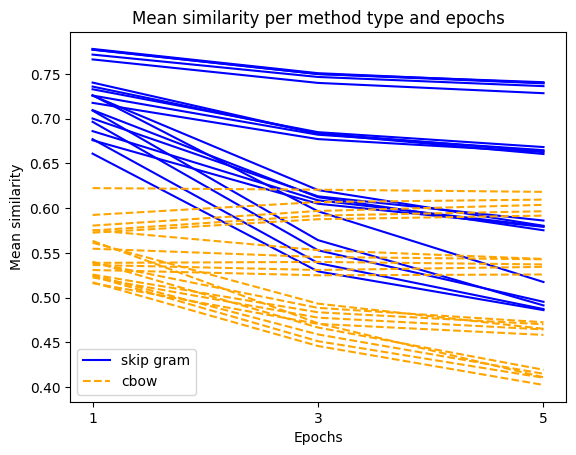

In [9]:
results_grouped = results_df.drop('qt processed', axis=1).groupby(by=['cbow', 'ctxt_size', 'emb_size'])
method_to_color_map = {"cbow": "orange", "skip gram": "blue"}
method_to_linestyle_map={"cbow":"--", "skip gram":"-"}
methods_shown = set()
for name, group in results_grouped:
    group_cbow, group_ctxt, group_emb = name
    its = list()
    group_mean_sim = list()
    first_it = None
    for row_idx, row in group.iterrows():
        its.append(row['it'])
        group_mean_sim.append(row['mean similarity'])
        if row_idx == 0:
            first_it=row['it']

    method = "skip gram" if group_cbow==0 else "cbow"
    label = None if method in methods_shown else method
    methods_shown.add(method)
    plt.plot(its, group_mean_sim, color=method_to_color_map[method],
                 linestyle=method_to_linestyle_map[method], label=label)

plt.title("Mean similarity per method type and epochs")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Mean similarity")
plt.xticks([1,3,5], [1,3,5])
plt.show()

O gráfico acima mostra que, ao fixar todas as outras configurações, realmente, os modelos tendem a piorar quanto mais épocas treinamos. Além disso, é possível perceber que todas as configurações que usam do *skip gram* tiveram performance melhor do que as configurações do cbow na primeira iteração.

Vamos ver o mesmo gráfico acima agrupado por tamanho de embedding:

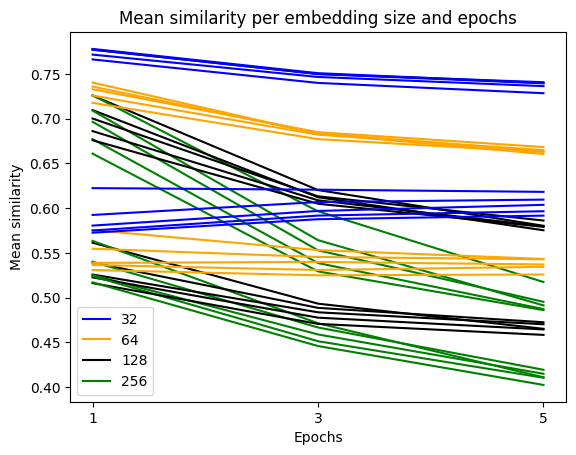

In [10]:
results_grouped = results_df.drop('qt processed', axis=1).groupby(by=['cbow', 'ctxt_size', 'emb_size'])
embeddings_to_color_map = {"32": "blue", "64": "orange", "128": "black", "256": "green"}
embeddings_shown = set()
for name, group in results_grouped:
    group_cbow, group_ctxt, group_emb = name
    its = list()
    group_mean_sim = list()
    first_it = None
    for row_idx, row in group.iterrows():
        its.append(row['it'])
        group_mean_sim.append(row['mean similarity'])
        if row_idx == 0:
            first_it=row['it']

    method = "skip gram" if group_cbow==0 else "cbow"
    embedding = str(int(row['emb_size']))
    label = None if embedding in embeddings_shown else embedding
    embeddings_shown.add(embedding)
    plt.plot(its, group_mean_sim, color=embeddings_to_color_map[embedding], label=label)

plt.title("Mean similarity per embedding size and epochs")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Mean similarity")
plt.xticks([1,3,5], [1,3,5])
plt.show()

De acordo com o gráfico acima, é possível perceber que usar de embeddings menores tende a ser positivo para a performance. Também é possível ver que a queda da similaridade média parece aumentar quanto maiores os embeddings usados. 

Finalmente, vamos agrupar por tamanho da janela de contexto:

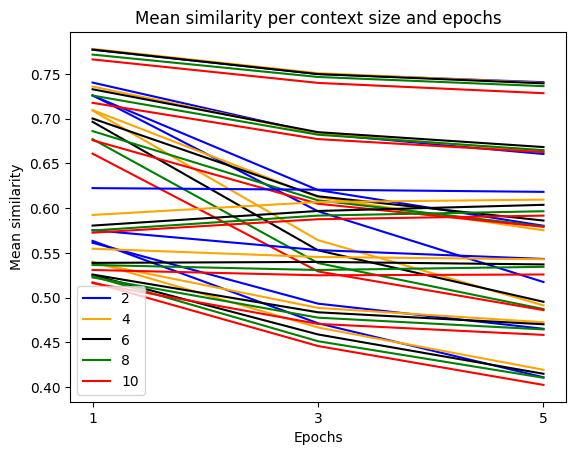

In [11]:
results_grouped = results_df.drop('qt processed', axis=1).groupby(by=['cbow', 'ctxt_size', 'emb_size'])
ctxt_to_color_map = {"2": "blue", "4": "orange", "6": "black", "8": "green", "10":"red"}
ctxt_shown = set()
for name, group in results_grouped:
    group_cbow, group_ctxt, group_emb = name
    its = list()
    group_mean_sim = list()
    first_it = None
    for row_idx, row in group.iterrows():
        its.append(row['it'])
        group_mean_sim.append(row['mean similarity'])
        if row_idx == 0:
            first_it=row['it']

    ctxt_size = str(int(row['ctxt_size']))
    label = None if ctxt_size in ctxt_shown else ctxt_size
    ctxt_shown.add(ctxt_size)
    plt.plot(its, group_mean_sim, color=ctxt_to_color_map[ctxt_size], label=label)

plt.title("Mean similarity per context size and epochs")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Mean similarity")
plt.xticks([1,3,5], [1,3,5])
plt.show()

Pelo gráfico acima, parece ter uma tendência de que, fixando todas as outras configurações, ao usar janelas de contexto maiores, a similaridade média cai.

# Considerações finais

O trabalho apresentado avaliou os *embeddings* gerados sobre um corpus de treinamento pelo algoritmo *word2vec* ao variar os seus principais parâmetros de treinamento. A avaliação se deu a partir do cálculo da similaridade média entre o vetor de *embedding* esperado com aquele gerado pela comparação de um conjunto de analogias.

Os resultados mostraram quatro tendências principais para melhorar a performance do modelo:

1. Usar o método *skip-gram* sobre o*cbow*
2. Usar tamanhos de *embeddings* menores
3. Usar de janelas de contexto menores
4. Realizar apenas uma época

O resultado de número 3 é bem conhecido na literatura, entretanto, os resultados 2 e 4 são contraintuitivos de forma geral. Mais especificamente, era esperado que, com tamanhos de embeddings maiores e mais épocas de treino, mais relações inerentes aos dados fossem aprendidas e houvesse a melhora de performance.
